# Lab 3


Importing Libraries


In [131]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import KBinsDiscretizer, LabelEncoder
from copy import  copy
import networkx as nx
import warnings
from functools import partial

from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination
from pgmpy.estimators import MaximumLikelihoodEstimator, MmhcEstimator, ExhaustiveSearch, BayesianEstimator, BDeuScore, K2Score, BicScore, HillClimbSearch, PC, TreeSearch
from pgmpy.sampling import BayesianModelSampling
from pgmpy.base import DAG

# warnings.filterwarnings("ignore",category=DeprecationWarning)
# warnings.filterwarnings("ignore",category=UserWarning)
# import warnings
warnings.filterwarnings('ignore')

# Importing Dataset from Google Drive 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
raw_data = pd.read_csv("/content/drive/MyDrive/DATASET/fraudTrain.csv")
raw_data.head(5)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [4]:
import os
os.listdir()

['Workshop3',
 'subsamples_lab_1.csv',
 'MMA_Lab_3_VA.ipynb',
 'task_4__final.ipynb',
 'subsamples_lab_2.csv',
 'lab_1.ipynb',
 'oldMMA_Report.pdf',
 'MMA_Lab_2.ipynb',
 'Credit Card Fraud Dataset',
 'Untitled.ipynb',
 'Workshop1.zip',
 'pdf_MaxL.csv',
 'preprocessed_data.csv',
 '.ipynb_checkpoints',
 'Workshop2',
 'Workshop3.zip',
 'Credit Card Fraud Dataset.zip',
 'Workshop1',
 'pdf_LSq.csv',
 'MMA_Lab3.ipynb']

# Pre Processing the Dataset

In [2]:
if 'preprocessed_data.csv' in os.listdir():
    df = pd.read_csv('preprocessed_data.csv', index_col=0)
else:
    df = raw_data.copy()
    df['trans_date_trans_time'] = raw_data['trans_date_trans_time'].apply(lambda x: pd.to_datetime(x))
    df['minute'] = df['trans_date_trans_time'].apply(lambda x: x.hour*60+x.minute)
    df['year_of_birth'] =  df['dob'].apply(lambda x: pd.to_datetime(x).year)
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,minute,year_of_birth
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0,1988
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0,1978
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0,1962
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,1,1967
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,3,1986


In [7]:
# os.listdir('./Workshop3')
pd.read_csv('./Workshop3/hackathon.csv').shape

(514, 15)

In [6]:
df.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'minute', 'year_of_birth'],
      dtype='object')

In [3]:
cols = ['category', 'amt', 'gender', 'state', 'lat', 'long', 'merch_lat', 'merch_long', 'city_pop', 'year_of_birth']
subsamples = df[cols].sample(5000)
subsamples.head()

,category,amt,gender,state,lat,long,merch_lat,merch_long,city_pop,year_of_birth
437747,travel,6.10,F,MO,37.3272,-91.0243,37.005507,-90.541327,241,1974
1162933,shopping_net,9.41,M,OH,40.0113,-80.9701,39.597666,-81.699608,128,1946
361969,gas_transport,61.43,F,NJ,41.0767,-74.5982,41.789081,-73.803343,2456,1994
100295,kids_pets,1.32,F,GA,30.9460,-83.2474,30.257341,-83.276681,94325,1987
886005,gas_transport,52.42,F,MN,46.9777,-96.4092,47.038615,-96.553975,4508,1949


We have a lot of categorical data, so we need to use LabelEncoder:

In [4]:
for column in ['category','gender','state']:
    le = LabelEncoder()
    subsamples[column] = le.fit_transform(subsamples[column].values)
subsamples.head()

,category,amt,gender,state,lat,long,merch_lat,merch_long,city_pop,year_of_birth
437747,13,6.10,0,23,37.3272,-91.0243,37.005507,-90.541327,241,1974
1162933,11,9.41,1,34,40.0113,-80.9701,39.597666,-81.699608,128,1946
361969,2,61.43,0,30,41.0767,-74.5982,41.789081,-73.803343,2456,1994
100295,7,1.32,0,9,30.9460,-83.2474,30.257341,-83.276681,94325,1987
886005,2,52.42,0,22,46.9777,-96.4092,47.038615,-96.553975,4508,1949


In [5]:
subsamples.to_csv('subsamples_lab_3.csv')
# subsamples = pd.read_csv('subsamples_lab_3.csv', index_col=0)

# Step 1: Variables
#### Predictors:
1. amt
2. merch_lat
3. lat
4. long
5. city_pop
6. merch_long
7. year_of_birth

#### Targets:
1. category
2. gender
3. state

Following is the Plots of the same.  

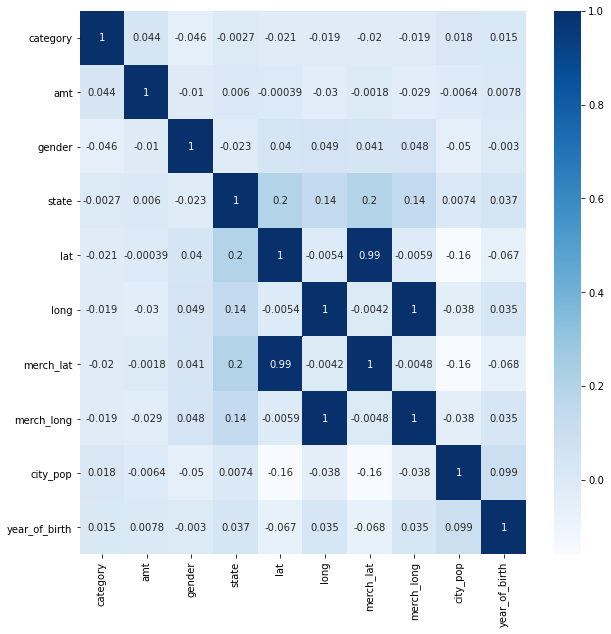

In [6]:
cols_x=['amt','lat', 'long', 'merch_lat', 'merch_long', 'city_pop', 'year_of_birth']
cols_y=['category', 'gender', 'state']

corrMatrix = subsamples.corr()
plt.rcParams['figure.figsize'] = [10, 10]
sns.heatmap(corrMatrix, annot=True, cmap='Blues')
plt.show()

# Step 2:
Using univariate parametric distributions that were fitted in Lab#2 make sampling of
chosen target variables. Use for this 2 different sampling methods.

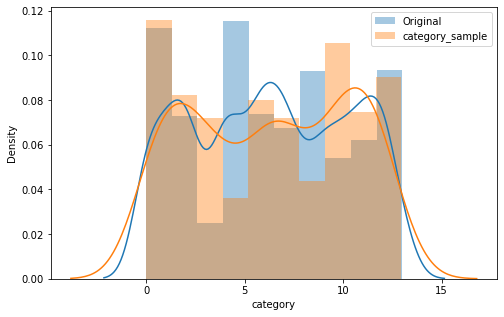

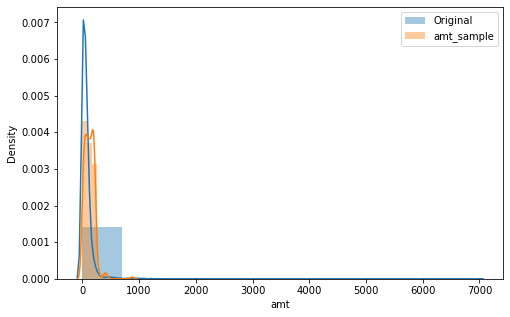

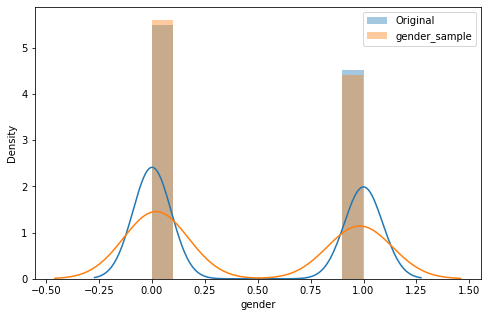

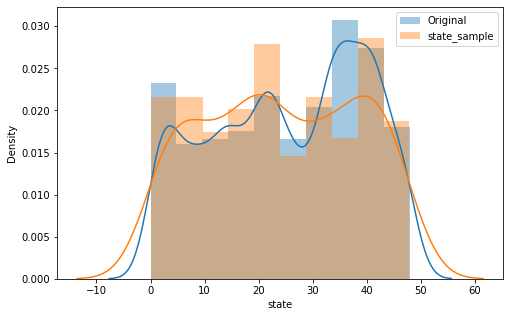

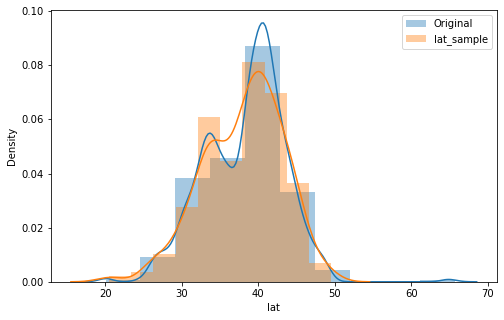

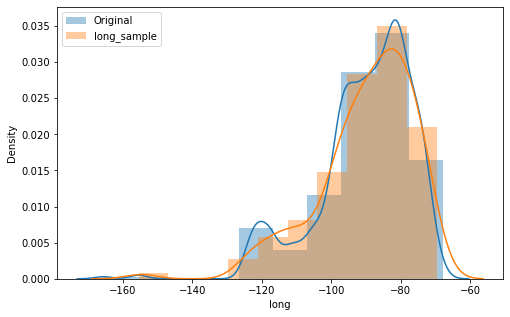

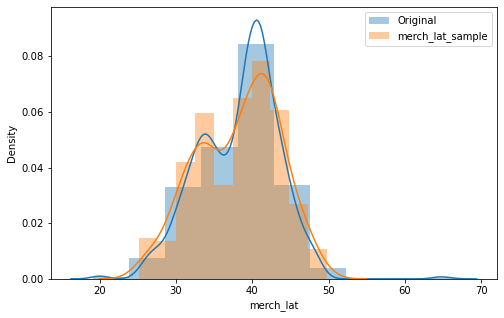

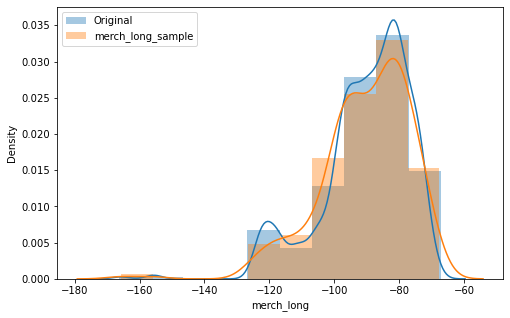

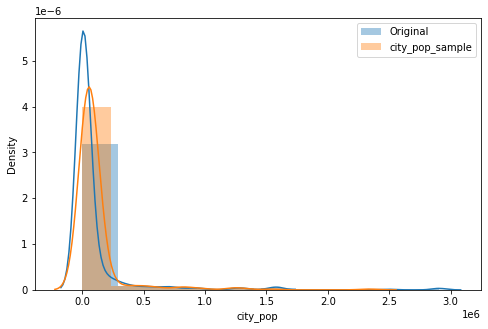

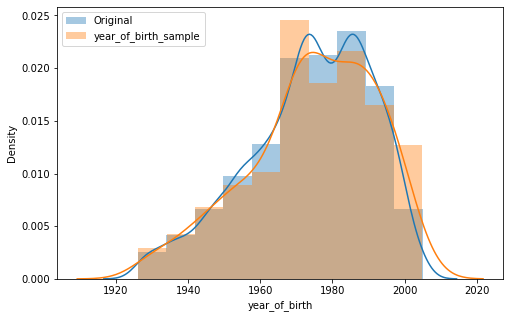

In [7]:
def inv_trans_sampling_hist(values, n_samples=1000):
    n_bins = int(1 + (3.322 * np.log(values.shape[0])).round())
    
    hist, bin_edges = np.histogram(values, bins=n_bins, density=True)
    
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist * np.diff(bin_edges))
    
    inversed_cdf = partial(np.interp, xp=cum_values, fp=bin_edges)
    uniform_values = np.random.rand(n_samples)
    
    return inversed_cdf(uniform_values), n_bins





df_ = subsamples.copy()

for target_var in subsamples:

    plt.figure(figsize=(8, 5))
    sampled_value, n_bins = inv_trans_sampling_hist(subsamples[target_var], n_samples=300)
#     x = np.linspace(sampled_value.min(), sampled_value.max(), len(sampled_value))
#     kde_values = stats.gaussian_kde(subsamples[target_var])(x)
# #     kde_values = kernel(x)
#     sns.histplot(sampled_value, stat='density', bins=10, kde=True, label=target_var+'_sample')
#     plt.title(target_var)
#     plt.plot(x, kde_values, 'r--', label='Original')
#     plt.ylabel('p')
#     plt.xlabel('sample')
#     plt.legend()
    sns.distplot(subsamples[target_var], bins=10, label='Original')
    sns.distplot(sampled_value, bins=10, label=target_var+'_sample')
    plt.legend()
    plt.show()

In [8]:
sampled_value.shape

(300,)

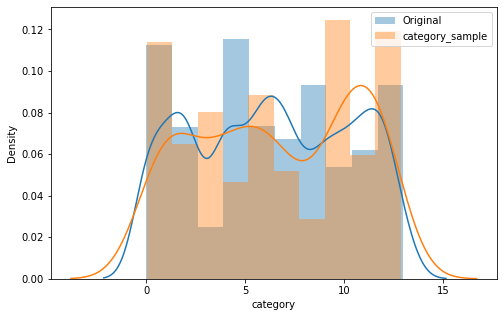

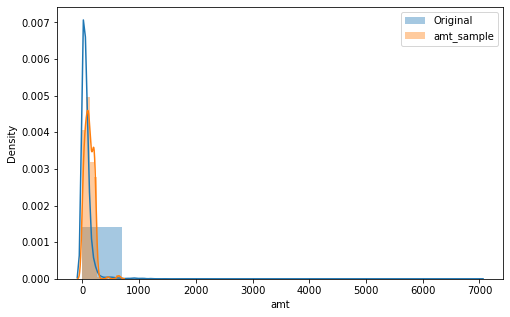

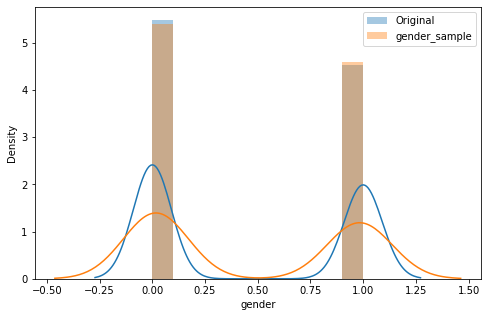

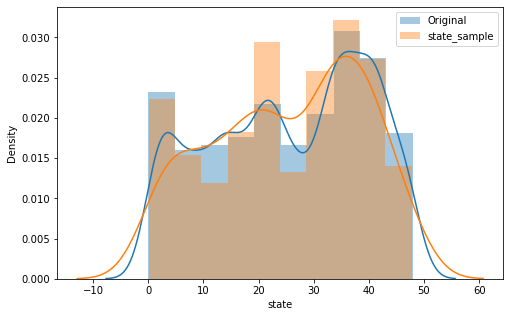

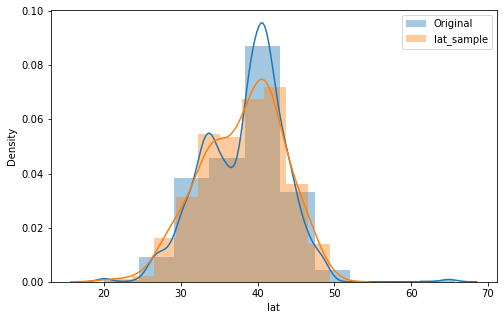

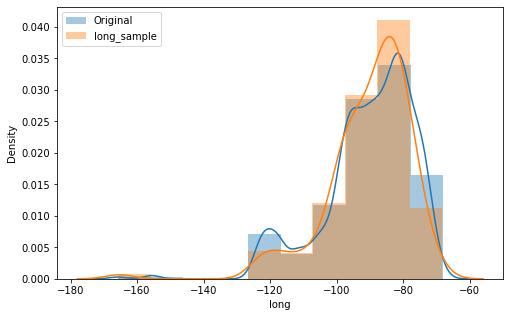

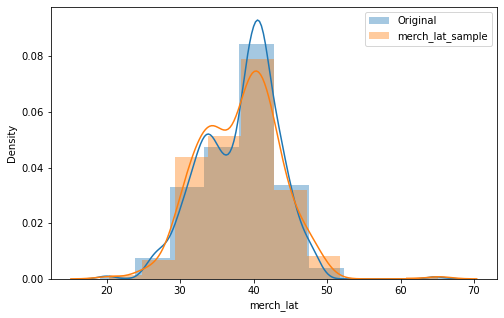

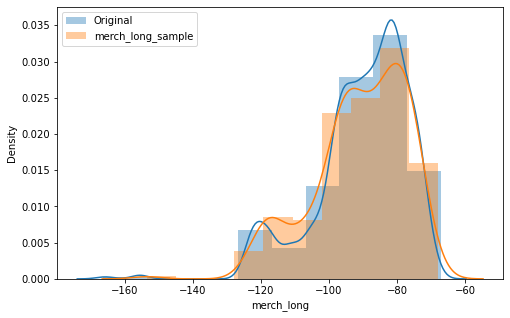

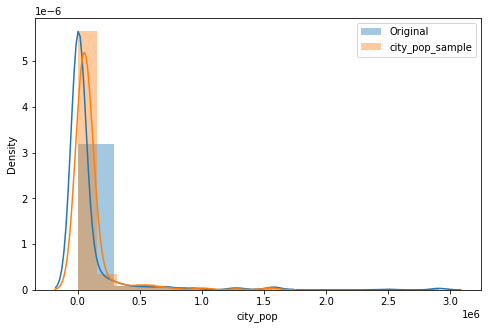

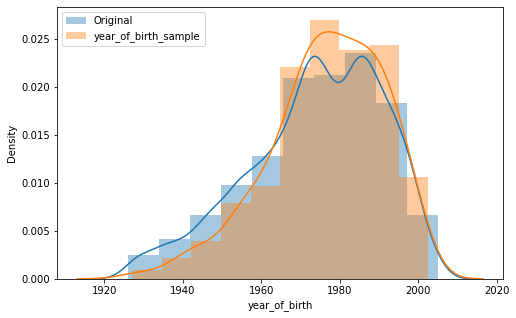

In [9]:
def geom_sampling_hist(values, n_samples=1000, batch_size=1000):

    n_bins = int(1 + (3.322 * np.log(values.shape[0])).round())
    hist, bin_edges = np.histogram(values, bins=n_bins, density=True)
    left, right = np.min(bin_edges), np.max(bin_edges)
    bottom, top = np.min(hist), np.max(hist)
    accept_samples = np.asarray([])
    
    while accept_samples.shape[0] < n_samples:
        x_sampl = np.random.uniform(left, right, size=(batch_size,))
        y_sampl = np.random.uniform(bottom, top, size=(batch_size,))
        x_indices = np.digitize(x_sampl, bin_edges) - 1
        y_mask = (y_sampl <= hist[x_indices])
        accept_samples = np.concatenate([accept_samples, x_sampl[y_mask]])
    
    return accept_samples[:n_samples], n_bins


sampled_inv = pd.DataFrame(cols)

for target_var in subsamples:

    plt.figure(figsize=(8, 5))
    sampled_value, n_bins = geom_sampling_hist(df_[target_var], n_samples=300)
    sns.distplot(subsamples[target_var], bins=10, label='Original')
    sns.distplot(sampled_value, bins=10, label=target_var+'_sample')
    plt.legend()
    plt.show()
    
#     x = np.linspace(sampled_value.min(), sampled_value.max(), len(sampled_value))
#     kernel = stats.gaussian_kde(subsamples[target_var])
#     kde_values = kernel(x)
#     sns.histplot(sampled_value, stat='density', bins=10, kde=True, label=target_var+'_sample')
#     plt.title(target_var)
#     plt.plot(x, kde_values, 'r--', label='Original')
#     plt.ylabel('p')
#     plt.xlabel('sample')
#     plt.legend()
#     plt.show()

Inverse transform sampling looks better, so we will use it further--------------- NO

In [54]:
# sampled_df=subsamples.apply(lambda col: inv_trans_sampling_hist(col, n_samples=300)[0], axis=0)
# print(sampled_df.shape)
# sampled_df.head()
sampled_df = subsamples.sample(1000)

# Step 3:
Estimate relations between predictors and chosen target variables. At least, they
should have significant correlation coefficients.

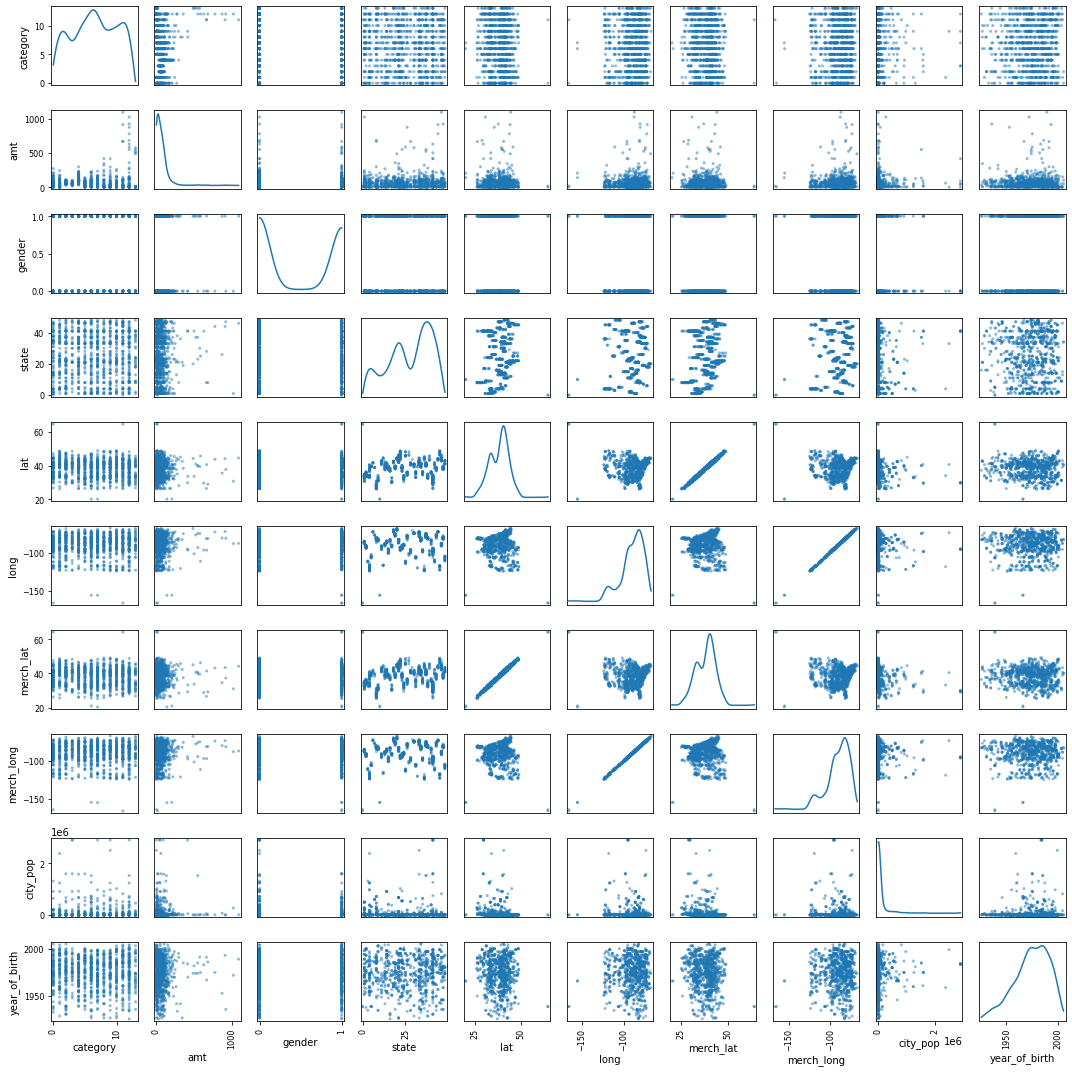

In [55]:
pd.plotting.scatter_matrix(sampled_df, diagonal="kde", figsize=(15, 15))
plt.tight_layout()
plt.show()

In [56]:
sampled_df.corr()[cols_y]

,category,gender,state
category,1.000000,-0.072654,-0.000798
amt,0.039414,0.018385,0.043047
gender,-0.072654,1.000000,-0.003923
state,-0.000798,-0.003923,1.000000
lat,-0.076932,0.023363,0.202167
long,0.030041,0.025190,0.119440
merch_lat,-0.074974,0.024313,0.202383
merch_long,0.032081,0.023383,0.115347
city_pop,-0.003491,-0.058377,-0.036609
year_of_birth,0.019690,0.046821,0.007856


It doesn't corellate much ¯\\_(ツ)_/¯

# Step 4
Build a Bayesian network for chosen set of variables. Choose its structure on the basis
of multivariate analysis and train distributions in nodes using chosen algorithm.

In [57]:
cols

['category',
 'amt',
 'gender',
 'state',
 'lat',
 'long',
 'merch_lat',
 'merch_long',
 'city_pop',
 'year_of_birth']

In [58]:
transformed_data = copy(sampled_df)
cols_to_transform = ['category',  'amt',  'state', 'lat', 'long', 'merch_lat', 'merch_long', 'city_pop', 'year_of_birth']
est = KBinsDiscretizer(n_bins=7, encode='ordinal', strategy='kmeans')
data_discrete = est.fit_transform(sampled_df[cols])
transformed_data[cols] = data_discrete

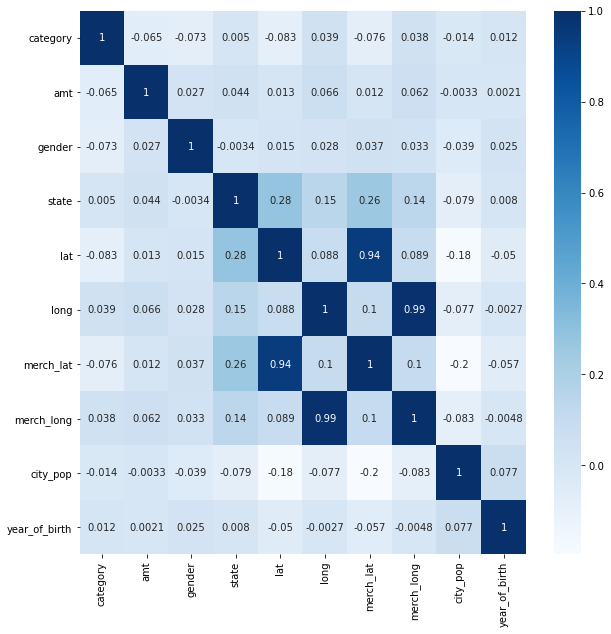

In [69]:
corrMatrix = transformed_data.corr()
plt.rcParams['figure.figsize'] = [10, 10]
sns.heatmap(corrMatrix, annot=True, cmap='Blues')
plt.show()

In [60]:
transformed_data.head()

,category,amt,gender,state,lat,long,merch_lat,merch_long,city_pop,year_of_birth
459886,4.0,1.0,0.0,0.0,4.0,6.0,3.0,6.0,0.0,3.0
1187612,2.0,1.0,1.0,5.0,2.0,3.0,1.0,3.0,0.0,3.0
267662,6.0,0.0,0.0,5.0,2.0,3.0,1.0,3.0,0.0,6.0
1138274,3.0,1.0,1.0,6.0,4.0,2.0,3.0,2.0,0.0,4.0
323852,3.0,0.0,0.0,6.0,5.0,1.0,4.0,1.0,0.0,1.0


In [68]:
cols_x, cols_y

(['amt',
  'lat',
  'long',
  'merch_lat',
  'merch_long',
  'city_pop',
  'year_of_birth'],
 ['category', 'gender', 'state'])

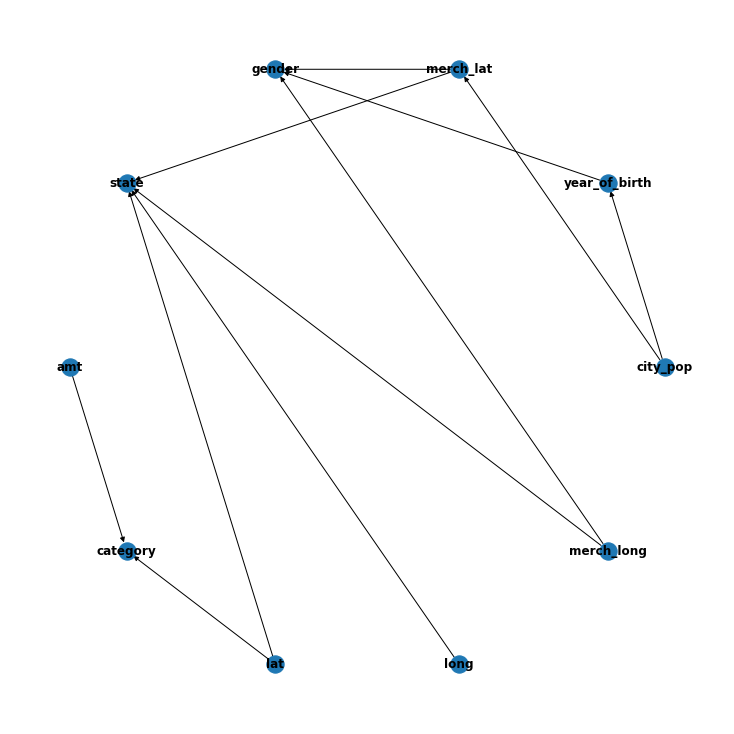

In [138]:
edges = {
    'city_pop': ['year_of_birth', 'merch_lat'],
    'year_of_birth': ['gender'],
    'amt': ['category'],
    'lat': ['category', 'state'],
    'merch_lat': ['gender', 'state'],
    'long': ['state'],
    'merch_long': ['gender', 'state']
#     "C6H6": ["S2", "S5"],
#     "NOx": ["NO2","S5"],
#     "T": ["AH"],
#     "S3": ["S5", "RH"],
#     "S2": ["S5", "S4"],
#    # "precipitation_amt_mm": [],
#     "AH": ["S4"],
}

edges_list = []
for out_var, in_vars in edges.items():
    for in_var in in_vars:
        edges_list.append((out_var, in_var))
        
# df_proc = df.copy()

# transformed_data = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
# data_discr = est.fit_transform(df_proc.values[:, 1:])
# df_proc[df_proc.columns[1:]] = data_discr

custom_model = BayesianModel(edges_list)
G_MAN = nx.DiGraph()
G_MAN.add_edges_from(custom_model.edges())
pos = nx.layout.circular_layout(G_MAN)
nx.draw(G_MAN, pos, with_labels=True, font_weight='bold')

In [141]:
custom_model.fit(transformed_data)

print(custom_model.check_model())

True


In [142]:
print(f"K2 score of custom model {K2Score(transformed_data).score(custom_model):.2f}")
print(f"BIC score of custom model {BicScore(transformed_data).score(custom_model):.2f}")

K2 score of custom model -13809.34
BIC score of custom model -65166.01


# Step 5
Build a Bayesian network for the same set of variables but using 2 chosen algorithms
for structural learning.

#### Hill Climb Search

In [143]:
hc = HillClimbSearch(transformed_data)

In [144]:
# default scoring is k2score according to documentation
blacklist = [(x, y) for y in transformed_data.columns.to_list() for x in ['category', 'state', 'gender'] if x != y]

model_hc = hc.estimate(scoring_method='k2score', black_list = blacklist, fixed_edges={('year_of_birth', 'gender')})

  0%|          | 0/1000000 [00:00<?, ?it/s]

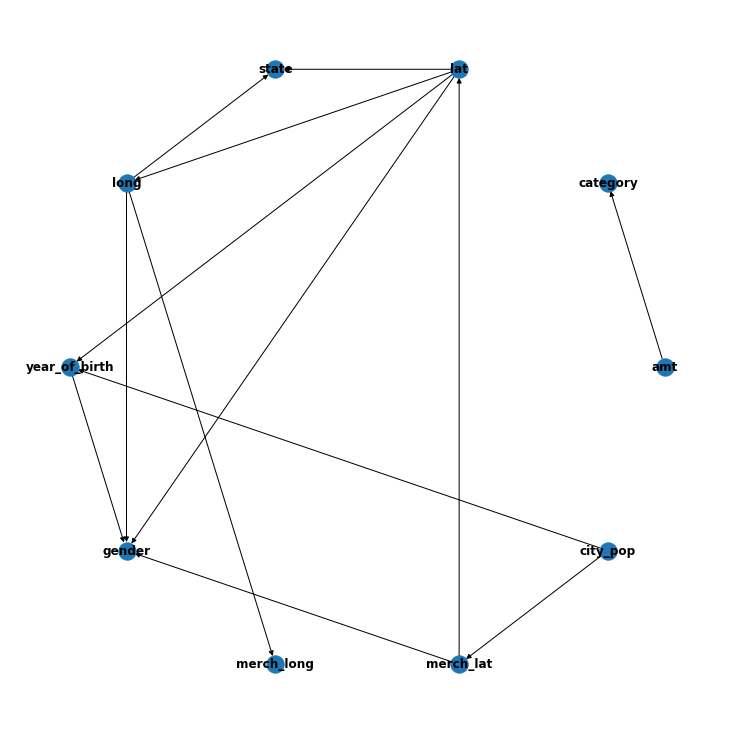

In [145]:
G_K2 = nx.DiGraph()
G_K2.add_edges_from(model_hc.edges())
pos = nx.layout.circular_layout(G_K2)
nx.draw(G_K2, pos, with_labels=True,font_weight='bold')

In [146]:
print(f"K2 score of unconstrained model {K2Score(transformed_data).score(model_hc):.2f}")
print(f"BIC score of unconstrained model {BicScore(transformed_data).score(model_hc):.2f}")

K2 score of unconstrained model -11165.67
BIC score of unconstrained model -21099.99


#### Tree-Search

Building tree:   0%|          | 0/45.0 [00:00<?, ?it/s]

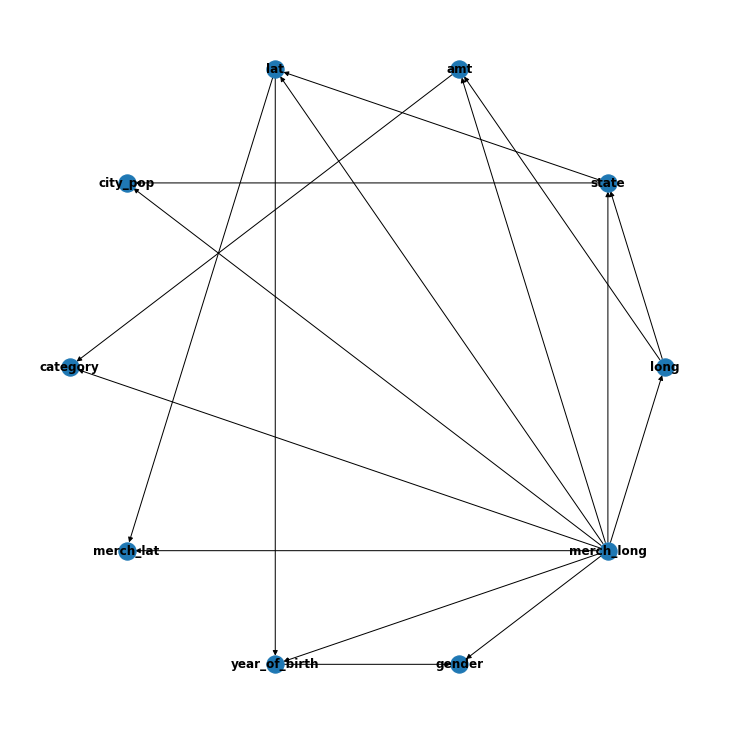

In [147]:
ts = TreeSearch(transformed_data)
model_ts = ts.estimate(estimator_type='tan')#, black_list=blacklist)
G_K2 = nx.DiGraph()
G_K2.add_edges_from(model_ts.edges())
pos = nx.layout.circular_layout(G_K2)
nx.draw(G_K2, pos, with_labels=True,font_weight='bold')

In [148]:
print(f"K2 score of unconstrained model {K2Score(transformed_data).score(model_ts):.2f}")
print(f"BIC score of unconstrained model {BicScore(transformed_data).score(model_ts):.2f}")

K2 score of unconstrained model -11917.56
BIC score of unconstrained model -17386.22


In [159]:
def sampling (bn: DAG, data: pd.DataFrame, n: int=100, new: bool=False):
    if new:
        bn_new = BayesianModel(bn.edges())
        bn_new.fit(data)
    else:
        bn_new = bn
    sampler = BayesianModelSampling(bn_new)
    sample = sampler.forward_sample(size=n)
    return sample

In [172]:
df_k2c = sampling(model_ts, transformed_data, n=transformed_data.shape[0], new=True)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

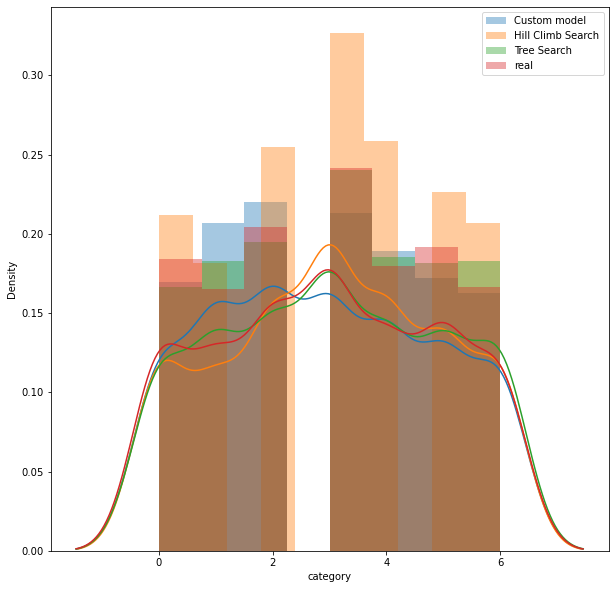

In [177]:
# sns.distplot(df_k2c['category'], label='Tree')
custom_res = sampling(custom_model, transformed_data, n=transformed_data.shape[0], new=True)
hc_res = sampling(model_hc, transformed_data, n=transformed_data.shape[0], new=True)
ts_res = sampling(model_ts, transformed_data, n=transformed_data.shape[0], new=True)

sns.distplot(custom_res['category'], label='Custom model')
sns.distplot(hc_res['category'], label='Hill Climb Search')
sns.distplot(ts_res['category'], label='Tree Search')
sns.distplot(transformed_data['category'], label='real')

plt.legend()
plt.show()

In [171]:
df_k2c.shape

(100, 10)

In [66]:
# def accuracy_params_restoration(bn: BayesianModel, data: pd.DataFrame):
#     bn.fit(data)
#     result = pd.DataFrame(columns=['Parameter', 'accuracy'])
#     bn_infer = VariableElimination(bn)
#     for j, param in enumerate(data.columns):
#         accuracy = 0
#         test_param = data[param]
#         test_data = data.drop(columns=param)
#         evidence = test_data.to_dict('records')
#         predicted_param = []
#         for element in evidence:
#             prediction = bn_infer.map_query(variables=[param], evidence=element)
#             predicted_param.append(prediction[param])
#         accuracy = accuracy_score(test_param.values, predicted_param)
#         result.loc[j,'Parameter'] = param
#         result.loc[j, 'accuracy'] = accuracy
#     return result

# accuracy_k2 = accuracy_params_restoration(BayesianModel(best_model.edges()), transformed_data)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

KeyboardInterrupt: 

In [ ]:
accuracy_k2.head()